In [11]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [111]:
# Load the CSV files into a list of DataFrames
data_dir = "data/keog/"

os.environ['OMP_NUM_THREADS'] = '1'

dataframes = []
dates = []
clusters = 20

for file in os.listdir(data_dir):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(data_dir, file))
        dataframes.append(df)
        first_date = df['datetime'].iloc[0][:10]
        dates.append(first_date)


In [112]:
# Ensure consistent shape by pivoting each DataFrame (time as columns, latitude as rows)
heatmaps = []

for df in dataframes:
    pivot_df = df.pivot(index='gdlat', columns='time_seconds', values='blrmvd')
    heatmaps.append(pivot_df)

# Convert each pivoted DataFrame to a flattened vector
dfs = [hm.values.flatten() for hm in heatmaps]

In [113]:
# Convert to NumPy array
dfs = np.array(dfs)

# Impute missing values with the column mean
imputer = SimpleImputer(strategy='mean')
heatmaps_imputed = imputer.fit_transform(dfs)

In [114]:
# Apply K-Means Clustering
kmeans = KMeans(n_clusters=clusters)  # Adjust number of clusters as needed
labels = kmeans.fit_predict(heatmaps_imputed)

c:\Users\Maria\anaconda3\envs\gradu\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [115]:
# Print the dates for each cluster
for i in range(clusters):
    cluster_indices = np.where(labels == i)[0]
    print(f"Cluster {i}:")
    for idx in cluster_indices:
        print(f" - Date: {dates[idx]}")

Cluster 0:
 - Date: 2023-01-18
Cluster 1:
 - Date: 2019-01-31
 - Date: 2020-07-04
 - Date: 2020-12-12
 - Date: 2021-04-27
 - Date: 2021-06-11
 - Date: 2021-06-20
 - Date: 2021-07-09
 - Date: 2021-10-23
 - Date: 2021-11-11
 - Date: 2021-12-22
 - Date: 2022-01-17
 - Date: 2022-01-21
 - Date: 2022-07-03
 - Date: 2022-07-19
Cluster 2:
 - Date: 2023-04-21
Cluster 3:
 - Date: 2022-03-13
Cluster 4:
 - Date: 2023-03-08
Cluster 5:
 - Date: 2021-07-24
 - Date: 2021-10-24
 - Date: 2021-11-01
 - Date: 2021-11-06
 - Date: 2022-02-07
 - Date: 2022-03-18
 - Date: 2022-04-02
 - Date: 2022-05-05
 - Date: 2022-05-17
 - Date: 2022-05-18
 - Date: 2022-06-01
 - Date: 2022-06-20
 - Date: 2022-07-21
 - Date: 2022-07-25
 - Date: 2022-07-26
 - Date: 2022-08-02
 - Date: 2022-09-06
 - Date: 2022-09-26
 - Date: 2022-10-05
 - Date: 2022-11-20
 - Date: 2022-12-10
Cluster 6:
 - Date: 2022-10-27
Cluster 7:
 - Date: 2022-10-09
Cluster 8:
 - Date: 2023-01-04
Cluster 9:
 - Date: 2023-03-19
 - Date: 2023-03-21
 - Date: 2

Cluster 0: 1 heatmaps


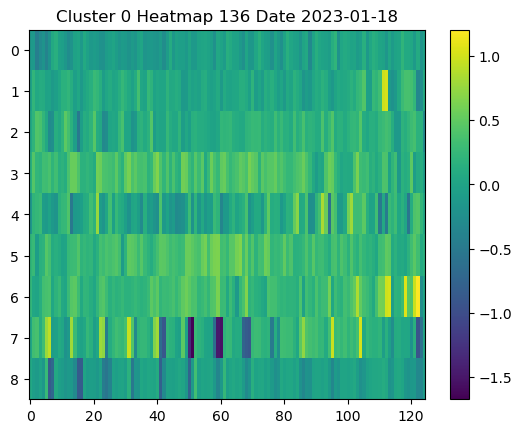

Cluster 1: 14 heatmaps


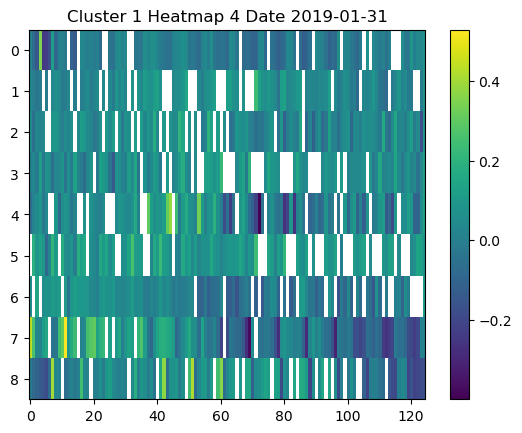

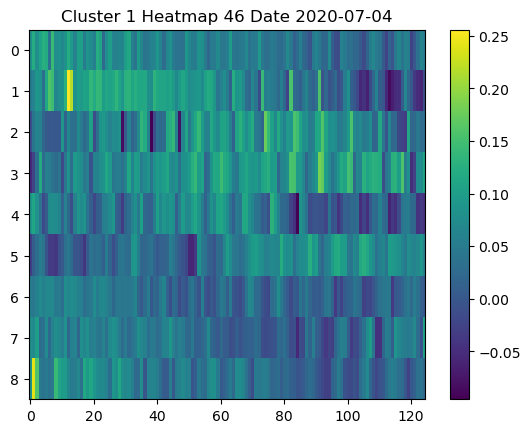

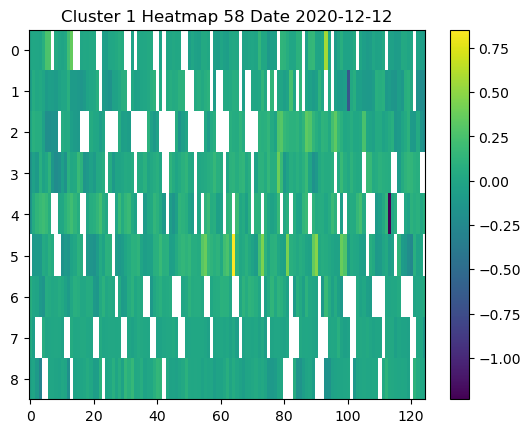

Cluster 2: 1 heatmaps


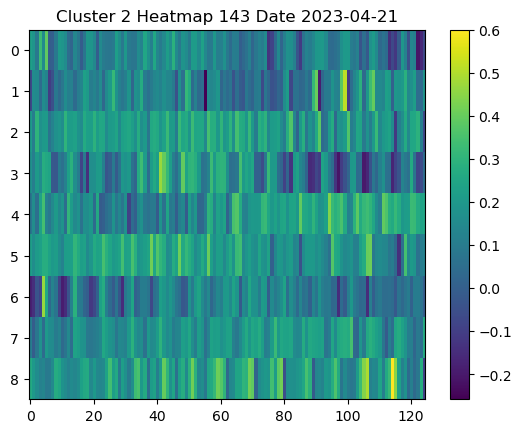

Cluster 3: 1 heatmaps


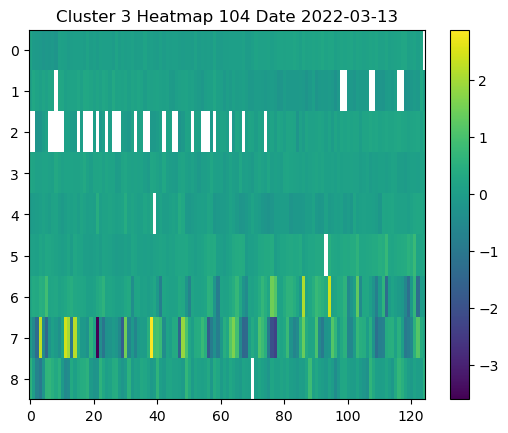

Cluster 4: 1 heatmaps


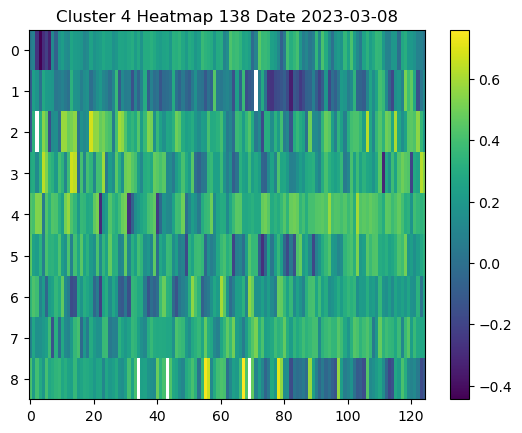

Cluster 5: 21 heatmaps


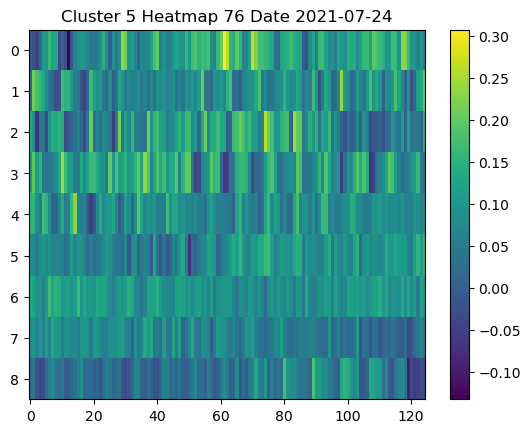

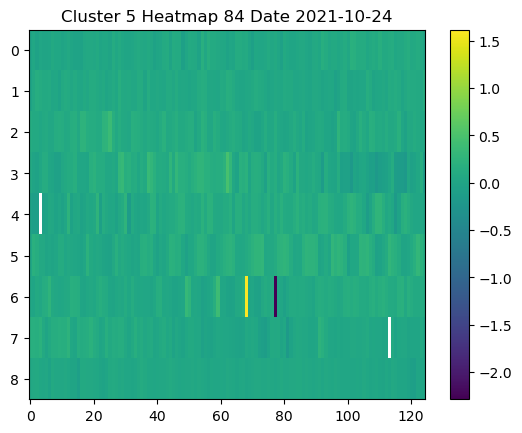

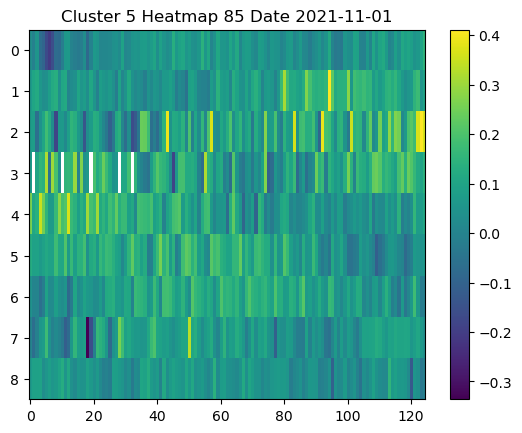

Cluster 6: 1 heatmaps


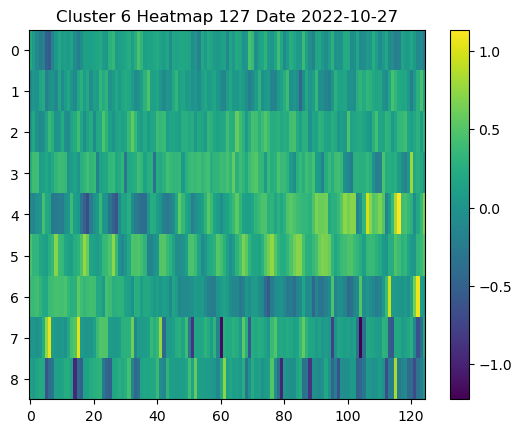

Cluster 7: 1 heatmaps


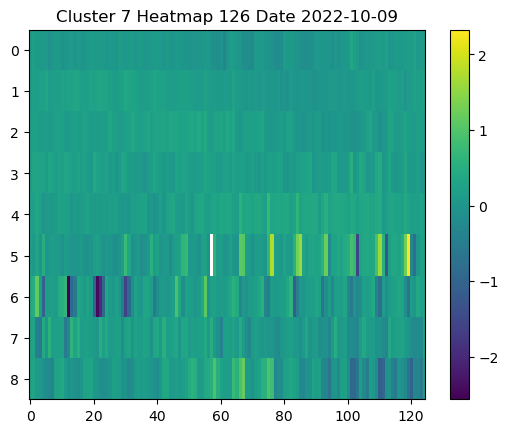

Cluster 8: 1 heatmaps


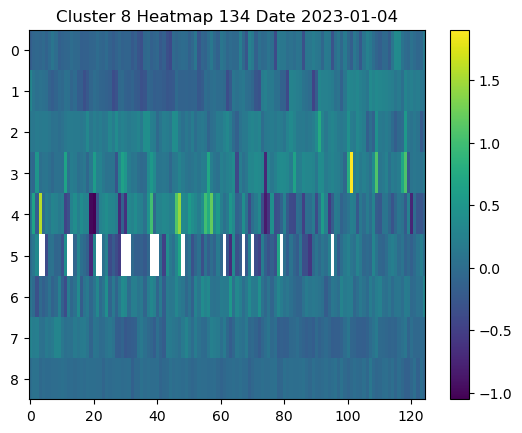

Cluster 9: 3 heatmaps


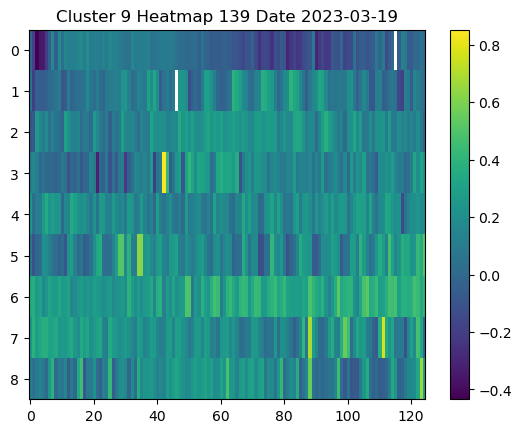

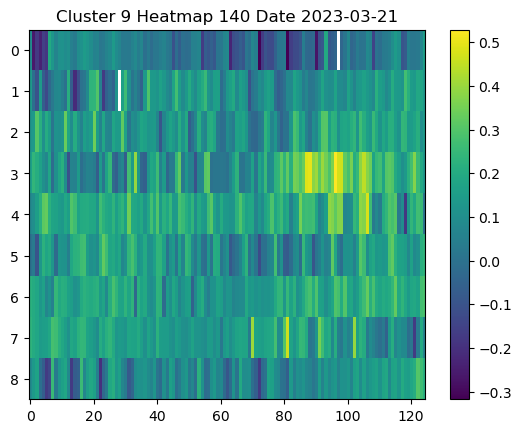

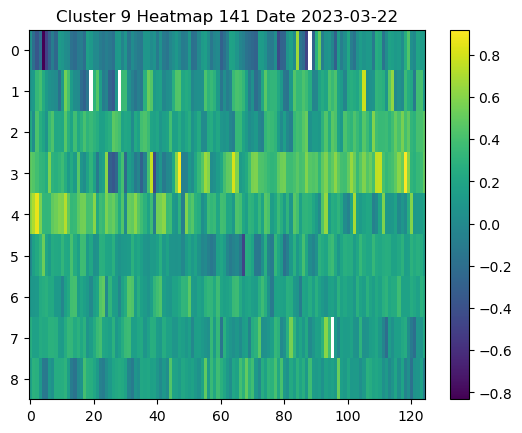

Cluster 10: 1 heatmaps


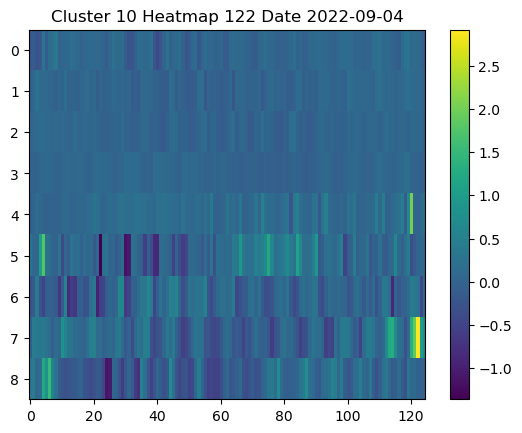

Cluster 11: 89 heatmaps


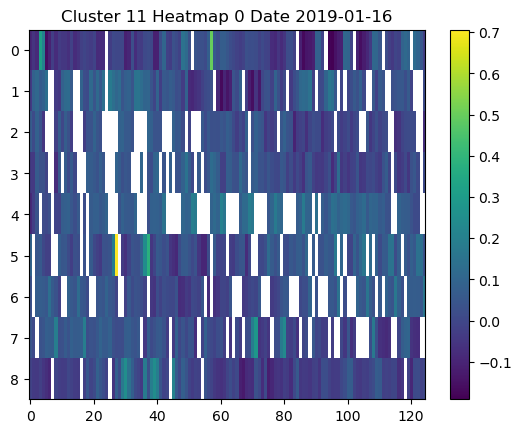

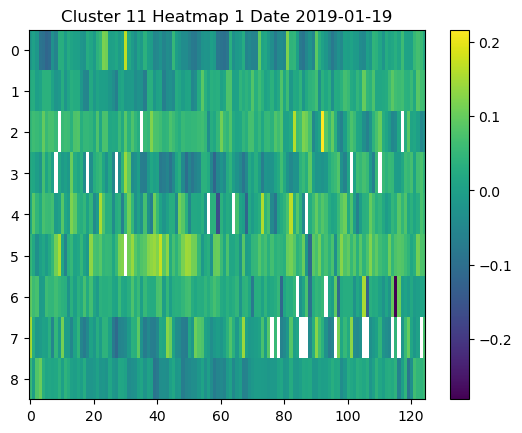

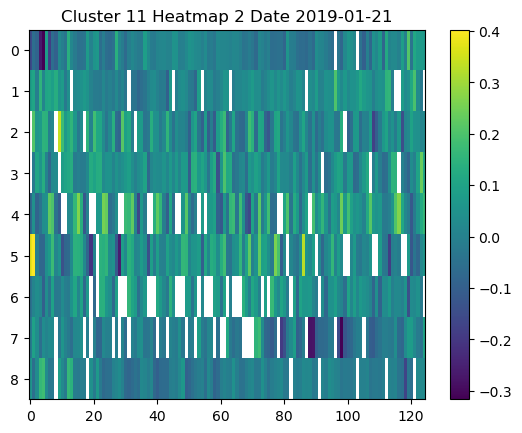

Cluster 12: 1 heatmaps


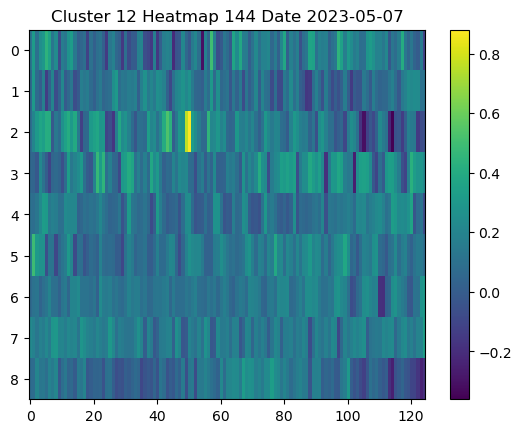

Cluster 13: 1 heatmaps


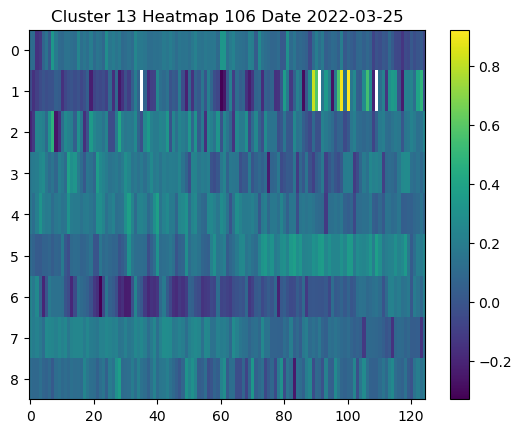

Cluster 14: 1 heatmaps


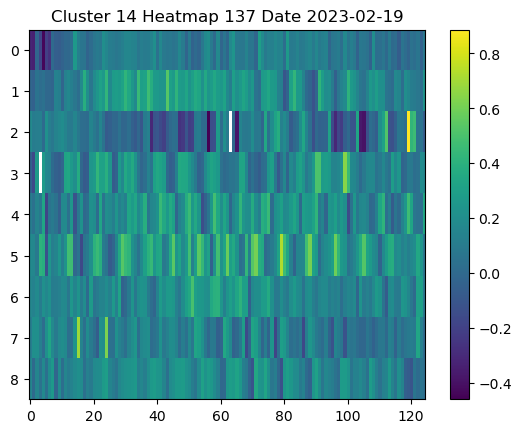

Cluster 15: 1 heatmaps


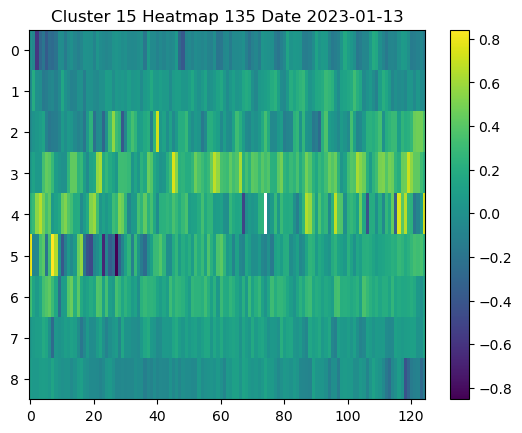

Cluster 16: 3 heatmaps


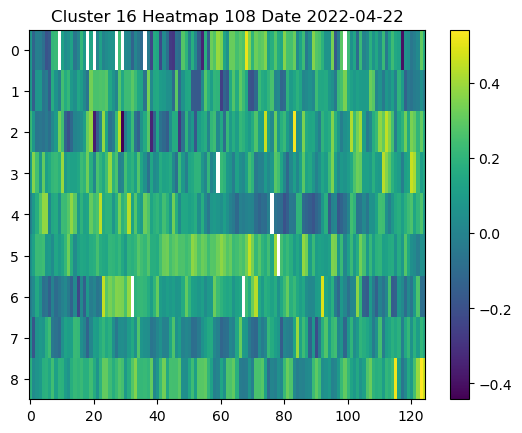

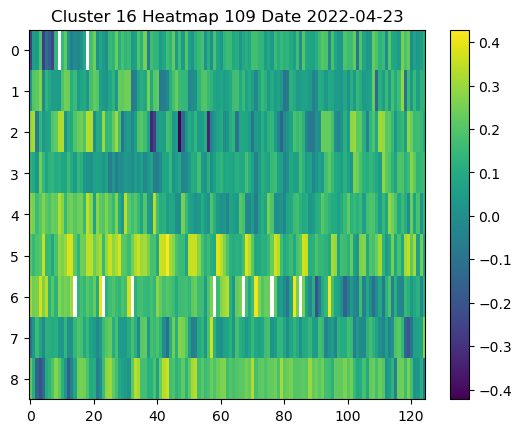

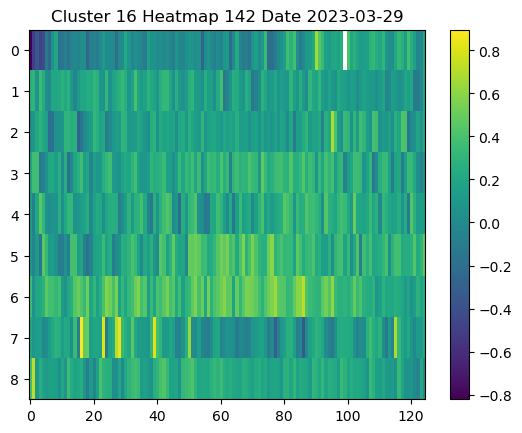

Cluster 17: 1 heatmaps


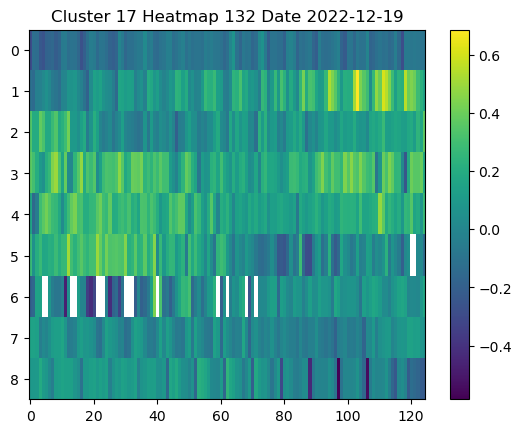

Cluster 18: 1 heatmaps


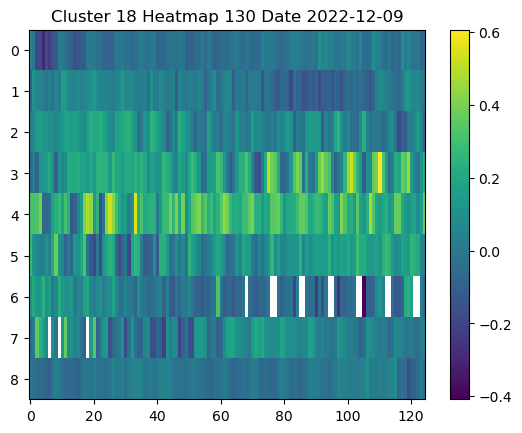

Cluster 19: 1 heatmaps


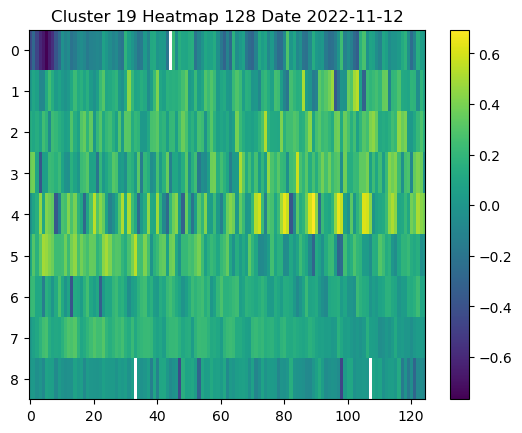

In [116]:
# Analyze the clusters
for i in range(clusters):
    cluster_indices = np.where(labels == i)[0]
    print(f"Cluster {i}: {len(cluster_indices)} heatmaps")
    # Optionally, visualize some of the heatmaps in this cluster
    for idx in cluster_indices[:3]:  # Show first 3 heatmaps in this cluster
        plt.imshow(heatmaps[idx], aspect='auto', cmap='viridis')
        plt.title(f"Cluster {i} Heatmap {idx} Date {dates[idx]}")
        plt.colorbar()
        plt.show()

In [117]:
labels

array([11, 11, 11, 11,  1, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  1, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11,  1, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11,  1, 11,  1, 11,  1,  1,  5, 11, 11, 11, 11, 11, 11,  1,  5,
        5,  5,  1, 11, 11, 11,  1, 11, 11, 11, 11, 11, 11, 11, 11, 11,  1,
        1,  5,  3,  5, 13,  5, 16, 16,  5,  5,  5, 11,  5,  5,  1,  1,  5,
        5,  5,  5, 10,  5,  5,  5,  7,  6, 19,  5, 18,  5, 17, 11,  8, 15,
        0, 14,  4,  9,  9,  9, 16,  2, 12])

In [118]:
data = {}
data['dates'] = dates
data['labels'] = labels

datadf = pd.DataFrame(data, columns=['dates', 'labels'])
datadf.to_csv(f'data/klusterit/klusteri{clusters}.csv')

In [119]:
dates

['2019-01-16',
 '2019-01-19',
 '2019-01-21',
 '2019-01-24',
 '2019-01-31',
 '2019-02-15',
 '2019-02-27',
 '2019-02-28',
 '2019-03-20',
 '2019-03-24',
 '2019-04-06',
 '2019-04-25',
 '2019-04-29',
 '2019-05-08',
 '2019-06-10',
 '2019-06-13',
 '2019-06-19',
 '2019-06-21',
 '2019-06-27',
 '2019-07-01',
 '2019-07-26',
 '2019-08-19',
 '2019-08-20',
 '2019-08-30',
 '2019-09-01',
 '2019-09-02',
 '2019-09-17',
 '2019-10-03',
 '2019-10-05',
 '2019-10-08',
 '2019-10-20',
 '2019-10-29',
 '2019-11-20',
 '2019-11-29',
 '2019-12-08',
 '2019-12-10',
 '2019-12-12',
 '2020-01-27',
 '2020-02-10',
 '2020-02-12',
 '2020-03-13',
 '2020-03-29',
 '2020-04-09',
 '2020-05-01',
 '2020-06-16',
 '2020-06-27',
 '2020-07-04',
 '2020-07-12',
 '2020-08-10',
 '2020-08-28',
 '2020-09-01',
 '2020-09-23',
 '2020-09-30',
 '2020-10-02',
 '2020-10-16',
 '2020-10-23',
 '2020-10-25',
 '2020-11-08',
 '2020-12-12',
 '2021-01-02',
 '2021-01-10',
 '2021-01-11',
 '2021-01-15',
 '2021-01-24',
 '2021-02-06',
 '2021-02-08',
 '2021-03-